[I 2026-02-02 22:51:26,436] A new study created in memory with name: no-name-363b91ce-0240-45ee-bbaa-3d787f6df266


Dataset shape: (1095, 6)


[I 2026-02-02 22:51:31,927] Trial 0 finished with value: 0.07704697549343109 and parameters: {'hidden': 64, 'dropout': 0.18798073459692277}. Best is trial 0 with value: 0.07704697549343109.
[I 2026-02-02 22:51:33,149] Trial 1 finished with value: 0.1549956053495407 and parameters: {'hidden': 107, 'dropout': 0.24269562454300161}. Best is trial 0 with value: 0.07704697549343109.
[I 2026-02-02 22:51:34,168] Trial 2 finished with value: 0.16984733939170837 and parameters: {'hidden': 94, 'dropout': 0.4187626955485133}. Best is trial 0 with value: 0.07704697549343109.
[I 2026-02-02 22:51:35,525] Trial 3 finished with value: 0.22019942104816437 and parameters: {'hidden': 126, 'dropout': 0.32462319730881056}. Best is trial 0 with value: 0.07704697549343109.
[I 2026-02-02 22:51:36,956] Trial 4 finished with value: 0.19592562317848206 and parameters: {'hidden': 94, 'dropout': 0.40695964497535997}. Best is trial 0 with value: 0.07704697549343109.
[I 2026-02-02 22:51:37,916] Trial 5 finished with 

Best params: {'hidden': 64, 'dropout': 0.18798073459692277}
Epoch 1 Loss: 0.5074
Epoch 2 Loss: 0.2138
Epoch 3 Loss: 0.3736
Epoch 4 Loss: 0.1288
Epoch 5 Loss: 0.1165
Epoch 6 Loss: 0.1208
Epoch 7 Loss: 0.1241
Epoch 8 Loss: 0.1961
Epoch 9 Loss: 0.1745
Epoch 10 Loss: 0.2107
Epoch 11 Loss: 0.1167
Epoch 12 Loss: 0.2950
Epoch 13 Loss: 0.1514
Epoch 14 Loss: 0.1475
Epoch 15 Loss: 0.3506
LSTM RMSE: 0.431
LSTM MAE : 0.344
LSTM MAPE: 253.97%


Non-invertible starting MA parameters found. Using zeros as starting parameters.


SARIMAX RMSE: 1.7280949748741454

SHAP Feature Importance
  Feature  Importance
0      f1    0.006908
1      f2    0.006908
2      f3    0.006908
3      f4    0.006908
4      f5    0.006908


Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


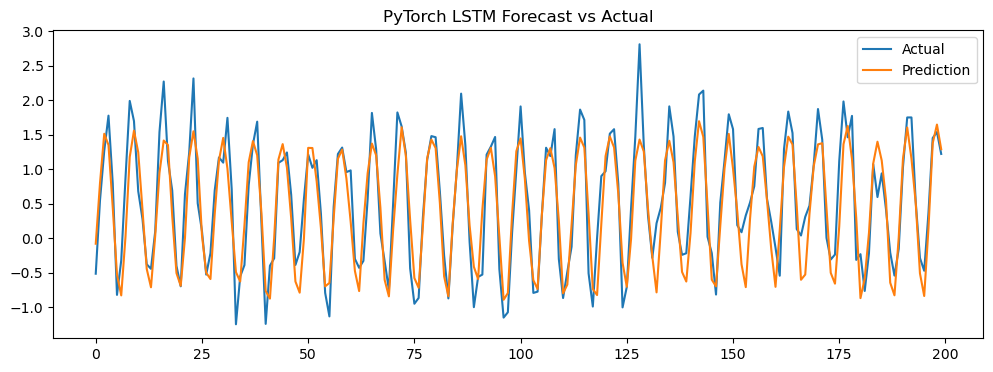

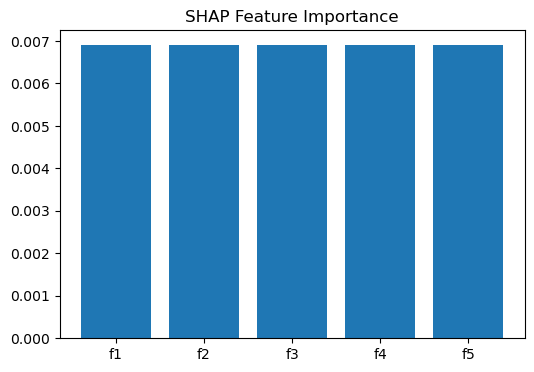

In [6]:
# ============================================================
# Advanced Time Series Forecasting with PyTorch + XAI (SHAP)
# Single-file Jupyter Notebook Implementation
# ============================================================

# ---------------------------
# 1. Imports
# ---------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import optuna
import shap

from statsmodels.tsa.statespace.sarimax import SARIMAX

torch.manual_seed(42)
np.random.seed(42)

# ---------------------------
# 2. Data Generation
# ---------------------------
days = 3 * 365
t = np.arange(days)

trend = 0.01 * t
seasonality = 10 * np.sin(2 * np.pi * t / 7)

f1 = trend + seasonality + np.random.normal(0, 2, days)
f2 = 0.8 * np.roll(f1, 1) + np.random.normal(0, 1, days)
f3 = np.random.normal(5, 1.5, days)
f4 = 0.5 * f1 + np.random.normal(0, 1, days)
f5 = np.random.normal(0, 3, days)

target = 0.4*f1 + 0.3*f2 + 0.2*f4 + np.random.normal(0, 2, days)

df = pd.DataFrame({
    "f1": f1,
    "f2": f2,
    "f3": f3,
    "f4": f4,
    "f5": f5,
    "target": target
})

print("Dataset shape:", df.shape)

# ---------------------------
# 3. Preprocessing & Sliding Window
# ---------------------------
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :-1])
        y.append(data[i+window, -1])
    return np.array(X), np.array(y)

WINDOW = 30
X, y = create_sequences(scaled, WINDOW)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32).view(-1,1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# ---------------------------
# 4. PyTorch LSTM Model
# ---------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

# ---------------------------
# 5. Optuna Hyperparameter Tuning
# ---------------------------
def objective(trial):
    hidden = trial.suggest_int("hidden", 32, 128)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = LSTMModel(5, hidden, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for _ in range(5):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    return loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)

# ---------------------------
# 6. Train Final Model
# ---------------------------
model = LSTMModel(5, study.best_params["hidden"], study.best_params["dropout"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(15):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

# ---------------------------
# 7. Evaluation
# ---------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()

y_true = y_test.numpy().flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"LSTM RMSE: {rmse:.3f}")
print(f"LSTM MAE : {mae:.3f}")
print(f"LSTM MAPE: {mape:.2f}%")

# ---------------------------
# 8. Baseline SARIMAX
# ---------------------------
sarimax = SARIMAX(y_true[:len(y_train)], order=(1,1,1), seasonal_order=(1,1,1,7))
sarimax_fit = sarimax.fit(disp=False)
sarimax_pred = sarimax_fit.forecast(len(y_true))

print("SARIMAX RMSE:",
      np.sqrt(mean_squared_error(y_true, sarimax_pred)))

# ---------------------------
# 9. SHAP Explainability
# ---------------------------
explainer = shap.DeepExplainer(model, X_train[:50])
shap_values = explainer.shap_values(X_test[:10])

importance = np.mean(np.abs(shap_values[0]), axis=(0,1))
features = ["f1","f2","f3","f4","f5"]

imp_df = pd.DataFrame({"Feature": features, "Importance": importance})
print("\nSHAP Feature Importance")
print(imp_df.sort_values("Importance", ascending=False))

# ---------------------------
# 10. Visualization
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(y_true[:200], label="Actual")
plt.plot(y_pred[:200], label="Prediction")
plt.legend()
plt.title("PyTorch LSTM Forecast vs Actual")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(imp_df["Feature"], imp_df["Importance"])
plt.title("SHAP Feature Importance")
plt.show()
